In [ ]:
# -*- coding: utf-8 -*-

"""
This software is part of GPU Ocean. 
Copyright (C) 2019 SINTEF Digital

This python program is used to set up and run a data-assimilation 
and drift trajectory forecasting experiment.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""


import sys, os, json, datetime, time, shutil
import numpy as np

current_dir = os.getcwd()

if os.path.isdir(os.path.abspath(os.path.join(current_dir, '../../SWESimulators'))):
        sys.path.insert(0, os.path.abspath(os.path.join(current_dir, '../../')))

In [ ]:
#--------------------------------------------------------------
# PARAMETERS
#--------------------------------------------------------------
args_ensemble_size = 100
args_method = "ETKF" 
args_observation_interval = 1
args_observation_variance = 1.0
args_observation_type = "buoys"
args_buoy_area = "all"
args_media_dir = "forecasting_results/"

args_num_days = 7
args_num_hours = 24
args_forecast_days = 3
args_profiling = False


# Checking input args
if args_ensemble_size is None:
    print("Ensemble size missing, please provide a --ensemble_size argument.")
    sys.exit(-1)
elif args_ensemble_size < 1:
    parser.error("Illegal ensemble size " + str(args.ensemble_size))

profiling = args_profiling


In [ ]:
###-----------------------------------------
## Define files for ensemble and truth.
##

ensemble_init_path = '../../../data/ensemble_init/'
assert len(os.listdir(ensemble_init_path)) == 100 or len(os.listdir(ensemble_init_path)) == 101, \
    "Ensemble init folder has wrong number of files: " + str(len(os.listdir(ensemble_init_path)))

truth_path = '../../../data/true_state/'
assert len(os.listdir(truth_path)) == 2 or len(os.listdir(truth_path)) == 3, \
    "Truth folder has wrong number of files"


timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
media_dir = args_media_dir
destination_dir = os.path.join(media_dir, "da_experiment_" +  timestamp + "/")
os.makedirs(destination_dir)

# Copy the truth into the destination folder
shutil.copytree(truth_path, os.path.join(destination_dir, 'truth'))

# Define misc filenames
log_file = os.path.join(destination_dir, 'description.txt')

particleInfoPrefix = os.path.join(destination_dir, 'particle_info_')
forecastFileBase = os.path.join(destination_dir, 'forecast_member_')


with open(log_file, 'w') as f:
    f.write('Data Assimilation experiment ' + timestamp + '\n')
    f.write('----------------------------------------------' + '\n')

def logParams():
    log('Input arguments:')
    #for arg in vars(args):
    #    log('\t' + str((arg, getattr(args, arg))))
    log('\nPath to initial conditions for ensemble:')
    log('\t' + ensemble_init_path)
    log('Path to true state:')
    log('\t' + truth_path)
    log('destination folder:')
    log('\t' + destination_dir)
    log('Path to particle info:')
    log('\t' + particleInfoPrefix)
    log('Path to forecast members:')
    log('\t' + forecastFileBase)

def log(msg, screen=True):
    with open(log_file, 'a') as f:
        f.write(msg + '\n')
    if screen:
        print(msg)
        
logParams()
        
    
# Reading and checking method
method = str(args_method).lower()
if method == 'iewpf2':
    log(' ----> Using IEWPF 2 stage method')
elif method == 'enkf':
    log(' ----> Using EnKF')
elif method == 'etkf':
    log(' ----> Using ETKF')
elif method == 'none':
    log(' ----> No data assimilation')
else:
    log('Illegal method: ' + str(method))
    sys.exit(-1)
    
    
# Time parameters
start_time      =  3*24*60*60 #  3 days in seconds
simulation_time = 10*24*60*60 # 10 days in seconds (three days spin up is prior to this)fa
end_time        = 13*24*60*60 # 13 days in seconds


# Based on truth from June 25th 2019
#drifterSet = [ 2, 7, 12, 24, 29, 35, 41, 48, 53, 60]
drifterSet = [ 2, 24, 60]

# Log extra information for the ensemble state for the following cells:
extraCells = np.array([[254, 241], # Cross with two trajectories
                       [249, 246], # northwest of above
                       [259, 236], # southeast of above
                       [343, 131], # Closed circle of same drifter
                       [196,  245], # Middle of single trajectory
                       [150,  250], # Middle of single trajectory, later than above
                       [102, 252], # On the same trajectory as the above, but later, and also in a intersection
                       [ 388, 100], # Unobserved area just north of southern jet
                       [ 388, 80],  # Unobserved area in southern jet
                       [ 388, 150], # Unobserved area in calm area
                      ])

Input arguments:

Path to initial conditions for ensemble:
	../../../data/ensemble_init/
Path to true state:
	../../../data/true_state/
destination folder:
	forecasting_results/da_experiment_2021_01_19-10_28_28/
Path to particle info:
	forecasting_results/da_experiment_2021_01_19-10_28_28/particle_info_
Path to forecast members:
	forecasting_results/da_experiment_2021_01_19-10_28_28/forecast_member_
 ----> Using ETKF


In [ ]:
###--------------------------------
# Import required packages
#
tic = time.time()
# For GPU contex:
from SWESimulators import Common
# For the ensemble:
from SWESimulators import EnsembleFromFiles, Observation
# For data assimilation:
from SWESimulators import IEWPFOcean
import ETKFOcean
# For forcasting:
from SWESimulators import GPUDrifterCollection
# For ObservationType:
from SWESimulators import DataAssimilationUtils as dautils

toc = time.time()
log("\n{:02.4f} s: ".format(toc-tic) + 'GPU Ocean packages imported', True)

# Create CUDA context
tic = time.time()
gpu_ctx = Common.CUDAContext()
device_name = gpu_ctx.cuda_device.name()
toc = time.time()
log("{:02.4f} s: ".format(toc-tic) + "Created context on " + device_name, True)


0.8933 s: GPU Ocean packages imported
0.7432 s: Created context on Quadro T2000


In [ ]:
###--------------------------
# Initiate the ensemble
#

observation_type = dautils.ObservationType.UnderlyingFlow
if args_observation_type == 'buoys':
    observation_type = dautils.ObservationType.StaticBuoys
    log('Observation type changed to StaticBuoys!')
elif args_observation_type == 'all_drifters':
    drifterSet = 'all'
    log('Using all drifters for DA experiment')

print(observation_type)

cont_write_netcdf = True and not profiling

tic = time.time()
ensemble = EnsembleFromFiles.EnsembleFromFiles(gpu_ctx, args_ensemble_size, \
                                               ensemble_init_path, truth_path, \
                                               args_observation_variance,
                                               cont_write_netcdf = cont_write_netcdf,
                                               use_lcg = True,
                                               write_netcdf_directory = destination_dir,
                                               observation_type=observation_type)

# Configure observations according to the selected drifters:
ensemble.configureObservations(drifterSet=drifterSet, 
                               observationInterval = args_observation_interval,
                               buoy_area = args_buoy_area)
ensemble.configureParticleInfos(extraCells)
toc = time.time()
log("{:02.4f} s: ".format(toc-tic) + "Ensemble is loaded and created", True)
log("Using drifterSet:\n" + str(drifterSet))
if args_observation_type == 'buoys':
    log('buoys to read:')
    log(str(ensemble.observations.read_buoy))


dt_ref = ensemble.particles[-1].dt

Observation type changed to StaticBuoys!
4
7.6002 s: Ensemble is loaded and created
Using drifterSet:
[2, 24, 60]
buoys to read:
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, 

In [ ]:
### -------------------------------
# Initialize DA class (if needed)
#
tic = time.time()
iewpf = None
if method.startswith('iewpf'):
    iewpf = IEWPFOcean.IEWPFOcean(ensemble)
    toc = time.time()
    log("{:02.4f} s: ".format(toc-tic) + "Data assimilation class IEWPFOcean initiated", True)
elif method.startswith('enkf'):
    enkf = EnKFOcean.EnKFOcean(ensemble)
    toc = time.time()
    log("{:02.4f} s: ".format(toc-tic) + "Data assimilation class EnKFOcean initiated", True)
elif method.startswith('etkf'):
    etkf = ETKFOcean.ETKFOcean(ensemble)
    toc = time.time()
    log("{:02.4f} s: ".format(toc-tic) + "Data assimilation class ETKFOcean initiated", True)
else:
    toc = time.time()
    log("{:02.4f} s: ".format(toc-tic) + "Skipping creation of a DA class", True)

    


0.0000 s: Data assimilation class ETKFOcean initiated


In [ ]:

### ----------------------------------------------
#   FUNCTIONALITIES FOR PLOTTING
#

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

import matplotlib.cm as cm


def imshow(im, interpolation="None", title=None, figsize=(4,4), interior=False):
    fig = plt.figure(figsize=figsize)
    
    if interior:
        im = plt.imshow(im[2:-2,2:-2], interpolation=interpolation, origin='lower')
    else:
        im = plt.imshow(im, interpolation=interpolation, origin='lower')
    
    plt.colorbar()
    if title is not None:
        plt.title(title)
        
def imshow3(eta, hu, hv, interpolation="None", title=None, figsize=(12.5,3.4), # (12.5, 3.4)
            color_bar_from_zero=False, save_filename=None, constant_range=False, pretitle='', max_eta=0.0, max_huv=0.0):
    
    fig, axs = plt.subplots(1,3, figsize=figsize)
    
    #fig = plt.figure(figsize=figsize)

    #gs = fig.add_gridspec(1,10)#, sharey=True)
    #axs = [None, None, None]
    #axs[0] = fig.add_subplot(gs[0, 1:4])
    #axs[1] = fig.add_subplot(gs[0, 4:7])
    #axs[2] = fig.add_subplot(gs[0, 7:10])
    
    eta_max = np.max(np.abs(eta))
    huv_max = max(np.max(np.abs(hu)), np.max(np.abs(hv)))
    
    if constant_range:
        eta_max = 3.5
        huv_max = 625

    if max_eta > 0.0:
        eta_max = max_eta
    if max_huv > 0.0:
        huv_max = max_huv
    
    eta_cmap = 'BrBG'
    huv_cmap = 'RdBu'
    
    eta_min = -eta_max
    huv_min = -huv_max
    if color_bar_from_zero:
        eta_min, huv_min = 0, 0
        if constant_range:
            eta_max = 0.12
            huv_max = 50
        
        eta_cmap = 'BuGn'
        huv_cmap = 'Blues'
        
    nx = ensemble.nx
    ny = ensemble.ny
    dx = ensemble.dx
    dy = ensemble.dy
    extent=np.array([0, nx*dx, 0, ny*dy]) / 1000
    
    
    fontsize = 18
    def addColorbar(ax, im, title):
        ax_divider = make_axes_locatable(ax)
        ax_cb = ax_divider.append_axes("top", size="10%", pad="5%")
        cbar = colorbar(im, cax=ax_cb, orientation="horizontal")
        ax_cb.xaxis.set_ticks_position("top")
        ax_cb.set_title(title, fontsize=fontsize)
    
    eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', 
                           vmin=eta_min, vmax=eta_max, extent=extent, cmap=eta_cmap) #GnBu')
    addColorbar(axs[0], eta_im, pretitle+"$\eta$ [m]")
    
    hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', 
                          vmin=huv_min, vmax=huv_max, extent=extent, cmap=huv_cmap)
    addColorbar(axs[1], hu_im, pretitle+"$hu$ [m$^2$/s]")
    
    
    hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower',
                          vmin=huv_min, vmax=huv_max, extent=extent, cmap=huv_cmap)
    addColorbar(axs[2], hv_im, pretitle+"$hv$ [m$^2$/s]")
    
    axs[0].set_ylabel("...", labelpad=3, fontsize=fontsize)
    
    #for ax in axs:
    #    ax.set_xlabel("$x$ [km]")
    #    ax.set_ylabel("$y$ [km]")
    
    if title is not None:
        plt.suptitle(r"\textbf{"+title+"}", y=1.1) #, fontsize=14)
    #plt.tight_layout()
    
    if save_filename is not None and savefigs:
        fig.savefig(result_dir + "/" + save_filename + ".png", bbox_inches='tight')
        fig.savefig(result_dir + "/" + save_filename + ".pdf", bbox_inches='tight')
        
        
    
def days_to_sec(days):
    return days*24*60*60

def sec_to_days(secs):
    return secs/(24*60*60)

def truth_time_step(t):
    t = t - days_to_sec(3)
    return int(t/(60*60))

def scatter3(x, y, hu, hv, title=None, figsize=(12.5,3.4), color_bar_from_zero=False, pretitle='', max_eta=0.0, max_huv=0.0):

    fig, axs = plt.subplots(1,3, figsize=figsize)
        
    eta_max = 3.5
    huv_max = 625

    if max_eta > 0.0:
        eta_max = max_eta
    if max_huv > 0.0:
        huv_max = max_huv
        
    eta_cmap = 'BrBG'
    huv_cmap = 'RdBu'
        
    eta_min = -eta_max
    huv_min = -huv_max
    if color_bar_from_zero:
        eta_min, huv_min = 0, 0
        if constant_range:
            eta_max = 0.12
            huv_max = 50
        
        eta_cmap = 'BuGn'
        huv_cmap = 'Blues'
            
        nx = ensemble.nx
        ny = ensemble.ny
        dx = ensemble.dx
        dy = ensemble.dy
        extent=np.array([0, nx*dx, 0, ny*dy]) / 1000
        
        
    fontsize = 18
    def addColorbar(ax, im, title):
        ax_divider = make_axes_locatable(ax)
        ax_cb = ax_divider.append_axes("top", size="10%", pad="5%")
        cbar = colorbar(im, cax=ax_cb, orientation="horizontal")
        ax_cb.xaxis.set_ticks_position("top")
        ax_cb.set_title(title, fontsize=fontsize)

    eta_im = axs[0].scatter(x, y, c=0*hu, vmin=eta_min, vmax=eta_max, cmap=eta_cmap, alpha=0.0) 
    addColorbar(axs[0], eta_im, pretitle+"$\eta$ [m]")

    hu_im = axs[1].scatter(x, y, c=hu, vmin=huv_min, vmax=huv_max, cmap=huv_cmap)
    addColorbar(axs[1], hu_im, pretitle+"$hu$ [m$^2$/s]")

    hv_im = axs[2].scatter(x, y, c=hv, vmin=huv_min, vmax=huv_max, cmap=huv_cmap)
    addColorbar(axs[2], hu_im, pretitle+"$hv$ [m$^2$/s]")   
        
    axs[0].set_ylabel("...", labelpad=3, fontsize=fontsize)

    if title is not None:
        plt.suptitle(r"\textbf{"+title+"}", y=1.1) #, fontsize=14)

In [ ]:

### ----------------------------------------------
#   FIRST DATA ASSIMILATION
#

obstime = start_time # time in seconds (starting after spin-up phase)

drifter_cells = ensemble.getDrifterCells()

log('------ Starting Simulation ---')

states_DA = np.zeros((ensemble.numParticles, ensemble.ny, ensemble.nx, 3, 3))

observations = np.zeros((ensemble.numParticles, ensemble.getNumDrifters(), 2, 2))

for minute in range(60):
    log('\n Simulate hour 01 minute {:02.0f} after spin-up'.format(minute+1))
    # Evolve 1 minute
    obstime += 60
    ensemble.stepToObservation(obstime)

    # At 5th minute EnKF applied
    if minute == 59:
        
        # Write priot
        for i in range(ensemble.numParticles):
            eta, hu, hv = ensemble.downloadParticleOceanState(i)
            states_DA[i,:,:,0,0] = eta
            states_DA[i,:,:,1,0] = hu
            states_DA[i,:,:,2,0] = hv

        observations[:,:,:,0] = ensemble.observeParticles()

        ensemble.writeEnsembleToNetCDF()
        # Write prior (end)
        
        etkf.ETKF(ensemble)

        # Write posterior 
        for i in range(ensemble.numParticles):
            eta, hu, hv = ensemble.downloadParticleOceanState(i)
            states_DA[i,:,:,0,1] = eta
            states_DA[i,:,:,1,1] = hu
            states_DA[i,:,:,2,1] = hv
        
        observations[:,:,:,1] = ensemble.observeParticles()
        # Write posterior (end)



------ Starting Simulation ---

 Simulate hour 01 minute 01 after spin-up

 Simulate hour 01 minute 02 after spin-up

 Simulate hour 01 minute 03 after spin-up

 Simulate hour 01 minute 04 after spin-up

 Simulate hour 01 minute 05 after spin-up

 Simulate hour 01 minute 06 after spin-up

 Simulate hour 01 minute 07 after spin-up

 Simulate hour 01 minute 08 after spin-up

 Simulate hour 01 minute 09 after spin-up

 Simulate hour 01 minute 10 after spin-up

 Simulate hour 01 minute 11 after spin-up

 Simulate hour 01 minute 12 after spin-up

 Simulate hour 01 minute 13 after spin-up

 Simulate hour 01 minute 14 after spin-up

 Simulate hour 01 minute 15 after spin-up

 Simulate hour 01 minute 16 after spin-up

 Simulate hour 01 minute 17 after spin-up

 Simulate hour 01 minute 18 after spin-up

 Simulate hour 01 minute 19 after spin-up

 Simulate hour 01 minute 20 after spin-up

 Simulate hour 01 minute 21 after spin-up

 Simulate hour 01 minute 22 after spin-up

 Simulate hour 01 minu

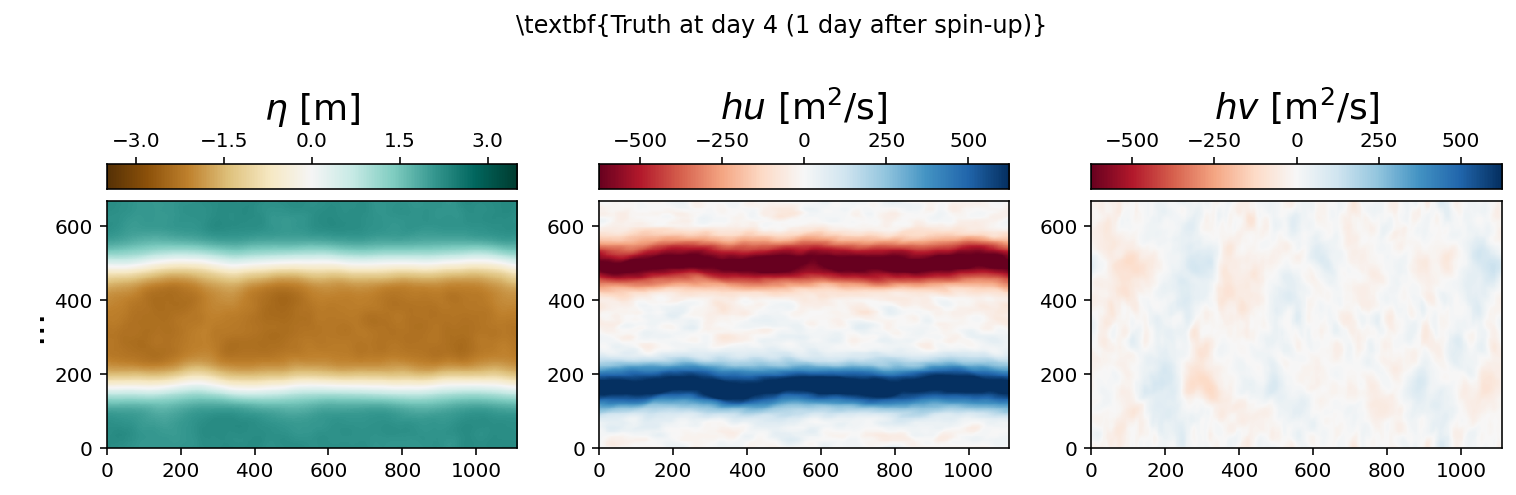

In [ ]:
### ----------------------------------------------
#   TRUTH AT DAY 3 HOUR 1
#

eta_true, hu_true, hv_true = ensemble.downloadTrueOceanState()

imshow3(eta_true, hu_true, hv_true, title='Truth at day 4 (1 day after spin-up)', constant_range=True)

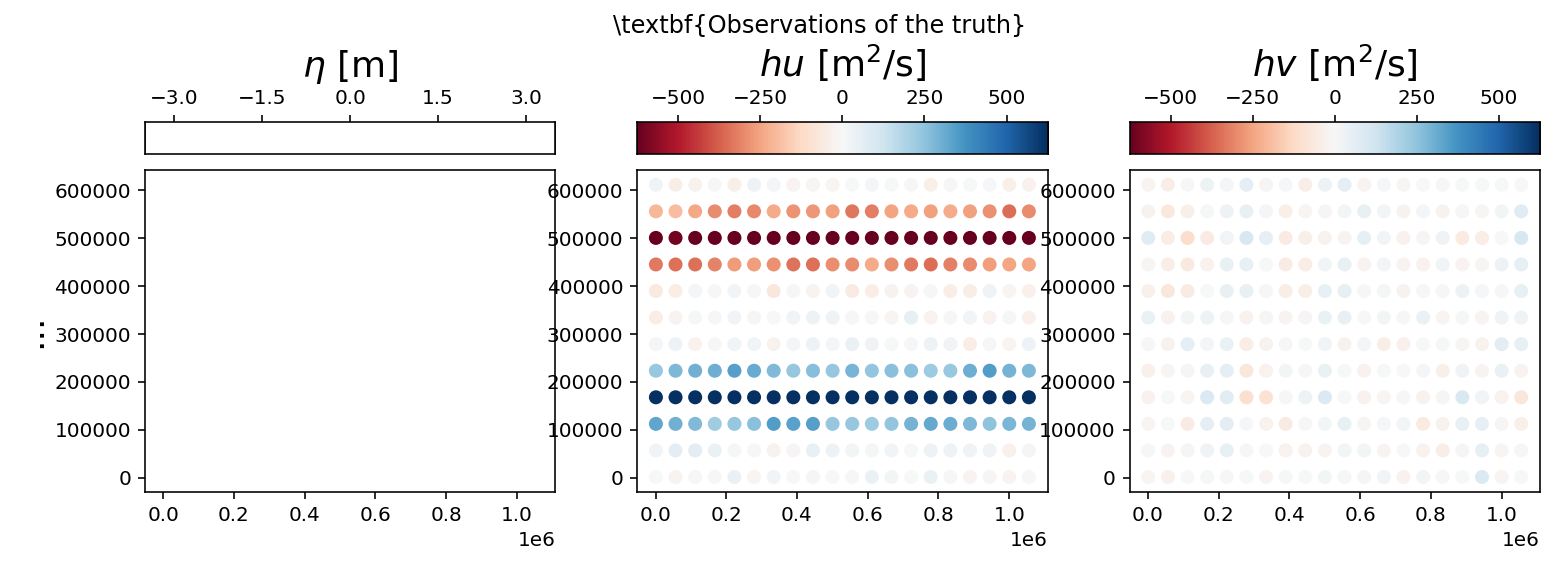

In [ ]:
### ----------------------------------------------
#   TRUE STATE OBSERVATIONS AT DAY 3 HOUR 1 
#

obs_true = ensemble.observeTrueState()

scatter3(obs_true[:,0],obs_true[:,1], obs_true[:,2], obs_true[:,3], title='Observations of the truth')

In [ ]:
### ----------------------------------------------
#   SET PARTICLE_ID FOR PLOTS
#

particle_id = 0

In [ ]:
states_DA[0,:,:,0,1]


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [ ]:

### ----------------------------------------------
#   BEFORE AND AFTER ANALYSIS FOR A SINGLE PARTICLE
#

imshow3(states_DA[particle_id,:,:,0,0],states_DA[particle_id,:,:,1,0],states_DA[particle_id,:,:,2,0], \
    title='Forecast for particle '+str(particle_id), constant_range=True)

imshow3(states_DA[particle_id,:,:,0,1],states_DA[particle_id,:,:,1,1],states_DA[particle_id,:,:,2,1], \
    title='Analysis for particle '+str(particle_id), constant_range=True)

imshow3(states_DA[particle_id,:,:,0,1]-states_DA[particle_id,:,:,0,0],\
    states_DA[particle_id,:,:,1,1]-states_DA[particle_id,:,:,1,0],\
    states_DA[particle_id,:,:,2,1]-states_DA[particle_id,:,:,2,0], \
    title = 'Update for particle '+str(particle_id))


ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.core.MaskedArray with masked values

In [ ]:
### ----------------------------------------------
#   BEFORE AND AFTER ANALYSIS FOR MEANS
#

states_mean = 1/states_DA.shape[0] * np.sum(states_DA, axis=0)

eta_prior_mean = states_mean[:,:,0,0]
hu_prior_mean  = states_mean[:,:,1,0]
hv_prior_mean  = states_mean[:,:,2,0]

eta_posterior_mean = states_mean[:,:,0,1]
hu_posterior_mean  = states_mean[:,:,1,1]
hv_posterior_mean  = states_mean[:,:,2,1]

imshow3(eta_prior_mean, hu_prior_mean, hv_prior_mean, title='Forecast mean', constant_range=True)

imshow3(eta_posterior_mean, hu_posterior_mean, hv_posterior_mean, title='Analysis mean', constant_range=True)

imshow3(eta_posterior_mean - eta_prior_mean,\
    hu_posterior_mean - hu_prior_mean,\
    hv_posterior_mean - hv_prior_mean, \
    title = 'Update mean')


In [ ]:
### ----------------------------------------------
#   DIFFERENCE TO TRUTH BEFORE AND AFTER DA
#

imshow3(eta_true - eta_prior_mean,\
    hu_true - hu_prior_mean,\
    hv_true - hv_prior_mean, \
    title = 'Error $\psi_{true} - \\frac{1}{N_e}\sum \psi_i$ before EnKF', max_eta=0.5, max_huv=175)

imshow3(eta_true - eta_posterior_mean,\
    hu_true - hu_posterior_mean,\
    hv_true - hv_posterior_mean, \
    title = 'Error  $\psi_{true} - \\frac{1}{N_e}\sum \psi_i$ after EnKF', max_eta=0.5, max_huv=175)



In [ ]:
### ----------------------------------------------
#   DIFFERENCE TO TRUTH BEFORE AND AFTER DA AT MOORINGS
#

obs_prior_mean = 1/observations.shape[0] * np.sum(observations[:,:,:,0], axis=0)
obs_posterior_mean = 1/observations.shape[0] * np.sum(observations[:,:,:,1], axis=0)

scatter3(obs_true[:,0],obs_true[:,1], obs_true[:,2]-obs_prior_mean[:,0], obs_true[:,3]-obs_prior_mean[:,1], \
    title='Error $H\psi_{true} - \\frac{1}{N_e}\sum H\psi_i$ before EnKF', max_huv=100.0)

scatter3(obs_true[:,0],obs_true[:,1], obs_true[:,2]-obs_posterior_mean[:,0], obs_true[:,3]-obs_posterior_mean[:,1], \
    title='Error $H\psi_{true} - \\frac{1}{N_e}\sum H\psi_i$ after EnKF', max_huv=100.0)


In [ ]:
### ----------------------------------------------
#   RMSE VS TRUTH BEFORE AND AFTER DA
#

eta_prior_rmse = np.zeros_like(eta_true)
hu_prior_rmse  = np.zeros_like(hu_true)
hv_prior_rmse  = np.zeros_like(hv_true)

for i in range(states_DA.shape[0]):
    eta_prior_rmse += 1/states_DA.shape[0] * (states_DA[i,:,:,0,0]-eta_true)**2
    hu_prior_rmse  += 1/states_DA.shape[0] * (states_DA[i,:,:,1,0]-hu_true)**2
    hv_prior_rmse  += 1/states_DA.shape[0] * (states_DA[i,:,:,2,0]-hv_true)**2

eta_posterior_rmse = np.zeros_like(eta_true)
hu_posterior_rmse  = np.zeros_like(hu_true)
hv_posterior_rmse  = np.zeros_like(hv_true)

for i in range(states_DA.shape[0]):
    eta_posterior_rmse += 1/states_DA.shape[0] * (states_DA[i,:,:,0,1]-eta_true)**2
    hu_posterior_rmse  += 1/states_DA.shape[0] * (states_DA[i,:,:,1,1]-hu_true)**2
    hv_posterior_rmse  += 1/states_DA.shape[0] * (states_DA[i,:,:,2,1]-hv_true)**2

imshow3(eta_prior_rmse,\
    hu_prior_rmse,\
    hv_prior_rmse, \
    title = 'RMSE vs truth before EnKF', max_eta= 0.2, max_huv = 25000)

imshow3(eta_posterior_rmse,\
    hu_posterior_rmse,\
    hv_posterior_rmse, \
    title = 'RMSE vs truth after EnKF', max_eta= 0.2, max_huv = 25000)

In [ ]:
### ----------------------------------------------
#   CONTINUE DATA ASSIMILATION SIMULATION
#

for minute in range(60):
    log('\n Simulate hour 02 minute {:02.0f} after spin-up'.format(minute+1))
    # Evolve 1 minute
    obstime += 60
    ensemble.stepToObservation(obstime)

    # At 5th minute EnKF applied
    if minute == 59:
        
        # Write prior
        for i in range(ensemble.numParticles):
            eta, hu, hv = ensemble.downloadParticleOceanState(i)
            states_DA[i,:,:,0,2] = eta
            states_DA[i,:,:,1,2] = hu
            states_DA[i,:,:,2,2] = hv
    

In [ ]:
### ----------------------------------------------
#   CONTINUE MONTE CARLO SIMULATION
#

from SWESimulators import CDKLM16

states_MC = np.zeros((ensemble.numParticles, ensemble.ny, ensemble.nx, 3))

for i in range(ensemble.numParticles):
    log('\n Simulate hour 02 after spin-up for particle {:02.0f}'.format(i))
    filename = media_dir + "/da_experiment_" +  timestamp + "/ensemble_member_{:04.0f}.nc".format(i)
    sim = CDKLM16.CDKLM16.fromfilename(gpu_ctx, filename, cont_write_netcdf=False)
    for minute in range(60):
        # Evolve 1 minute
        obstime += 60
        sim.dataAssimilationStep(obstime,write_now=False)

        # At 5th minute EnKF applied
        if minute == 59:
            
            # Write prior
            eta, hu, hv = sim.download(interior_domain_only=True)
            states_MC[i,:,:,0] = eta
            states_MC[i,:,:,1] = hu
            states_MC[i,:,:,2] = hv
    


In [ ]:
### ----------------------------------------------
#   TRUTH AT DAY 3 HOUR 2
#

eta_true, hu_true, hv_true = ensemble.downloadTrueOceanState()

imshow3(eta_true, hu_true, hv_true, title='Truth at day 4 hour 2', constant_range=True)

In [ ]:
### ----------------------------------------------
#   RMSE VS TRUTH WITH AND WITHOUT DA
#

eta_da_rmse = np.zeros_like(eta_true)
hu_da_rmse  = np.zeros_like(hu_true)
hv_da_rmse  = np.zeros_like(hv_true)

for i in range(states_DA.shape[0]):
    eta_da_rmse += 1/states_DA.shape[0] * (states_DA[i,:,:,0,2]-eta_true)**2
    hu_da_rmse  += 1/states_DA.shape[0] * (states_DA[i,:,:,1,2]-hu_true)**2
    hv_da_rmse  += 1/states_DA.shape[0] * (states_DA[i,:,:,2,2]-hv_true)**2

eta_mc_rmse = np.zeros_like(eta_true)
hu_mc_rmse  = np.zeros_like(hu_true)
hv_mc_rmse  = np.zeros_like(hv_true)

for i in range(states_DA.shape[0]):
    eta_mc_rmse += 1/states_MC.shape[0] * (states_MC[i,:,:,0]-eta_true)**2
    hu_mc_rmse  += 1/states_MC.shape[0] * (states_MC[i,:,:,1]-hu_true)**2
    hv_mc_rmse  += 1/states_MC.shape[0] * (states_MC[i,:,:,2]-hv_true)**2

imshow3(eta_da_rmse,\
    hu_da_rmse,\
    hv_da_rmse, \
    title = 'RMSE vs truth at day 3 hour 2 with DA', max_eta= 0.2, max_huv = 25000)

imshow3(eta_mc_rmse,\
    hu_mc_rmse,\
    hv_mc_rmse, \
    title = 'RMSE vs truth at day 3 hour 2 without DA', max_eta= 0.2, max_huv = 25000)


In [ ]:
# Clean up simulation and close netcdf file
tic = time.time()
sim = None
ensemble.cleanUp()
toc = time.time()
print("\n{:02.4f} s: ".format(toc-tic) + "Clean up simulator done.")

log('Done! Only checking is left. There should be a "yes, done" in the next line')

if not profiling:
    assert(numDays == 7), 'Simulated with wrong number of days!'
    assert(numHours == 24), 'Simulated with wrong number of hours'
    assert(forecast_end_time == 13*24*60*60), 'Forecast did not reach goal time'

log('Yes, done!')